In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import pylab as plt
import back_test_bot as bb
import matplotlib.ticker as mtick

In [3]:
df = bb.fetch_btc_history(interval="1h", start_date="2016-01-01")

In [77]:
# Compute rolling VWAP
df["vwap"] = bb.rolling_vwap(df, window=3)

In [78]:
# Detect deviations > 3%
df = bb.detect_deviation(df, threshold=0.01)

In [79]:
df = bb.trade_direction(df)

In [80]:
df = bb.best_bot(df)

In [81]:
df_sample = df.tail(200)

In [82]:
def plot_trade_events(df):
    fig, ax = plt.subplots(figsize=(10,8))
    df.plot(ax=ax, x='timestamp',y='price')
    df.plot(ax=ax, x='timestamp',y='deviation',secondary_y=True,alpha=0.2,ls='-.')
    df.plot(ax=ax, x='timestamp',y='vwap',color='k',ls=':')
    df[df['direction']==1].plot.scatter(ax=ax, x='timestamp',y='price', color='green',label = 'buy')
    df[df['direction']==-1].plot.scatter(ax=ax, x='timestamp',y='price', color='red', label = "sell")
    ax.legend(ncols=5)

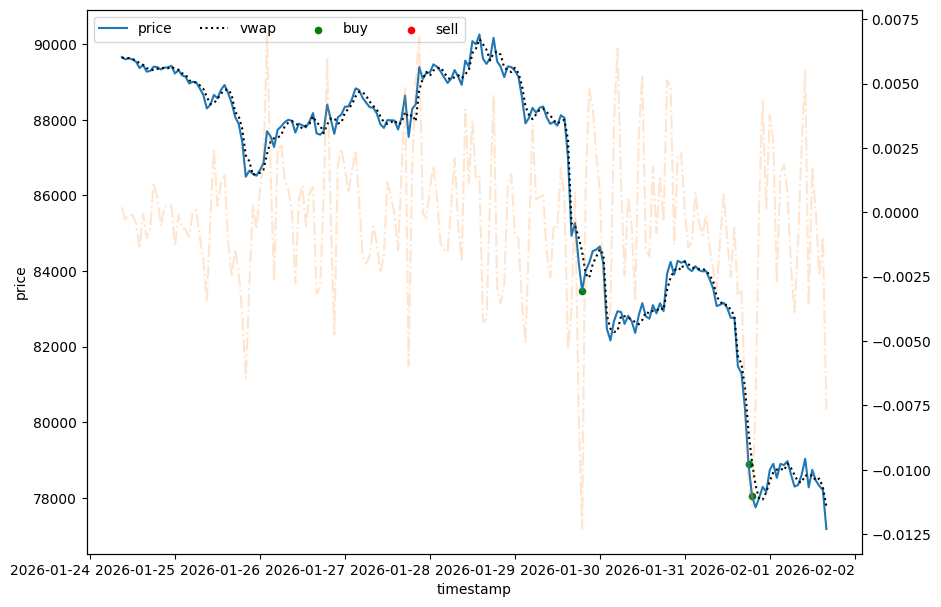

In [83]:
plot_trade_events(df_sample)

In [85]:
df['direction'].value_counts()

direction
 0    70717
-1     1701
 1     1626
Name: count, dtype: int64

#### Populate wallet

In [86]:
df = bb.update_wallet(df, wallet_value=100, wallet_value_fraction=0.2)

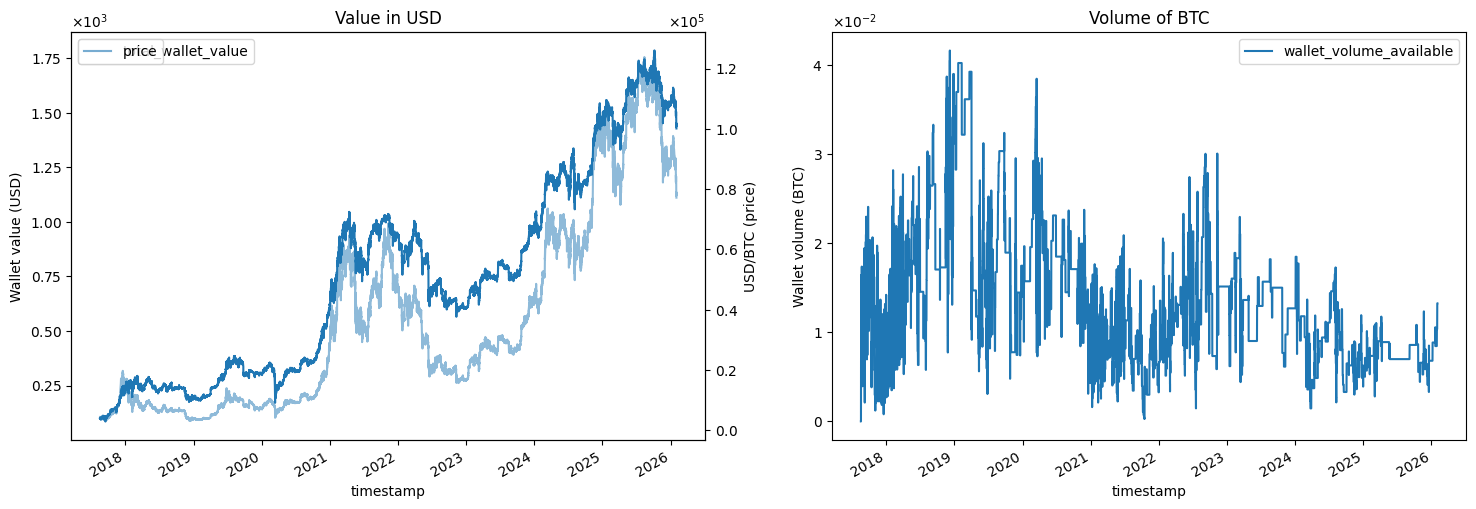

In [87]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))

# Left panel
df.plot(ax=ax[0], x='timestamp', y='total_wallet_value', ylabel="Wallet value (USD)", title="Value in USD")
ax[0].yaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

ax2 = ax[0].twinx()
df.plot(ax=ax2, x='timestamp', y='price', alpha=0.5, ylabel="USD/BTC (price)")
ax2.yaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

# Right panel
df.plot(ax=ax[1], x='timestamp', y='wallet_volume_available', ylabel="Wallet volume (BTC)", title="Volume of BTC")
ax[1].yaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))


<Axes: title={'center': 'Normalised value'}, xlabel='timestamp', ylabel='Factor of gains'>

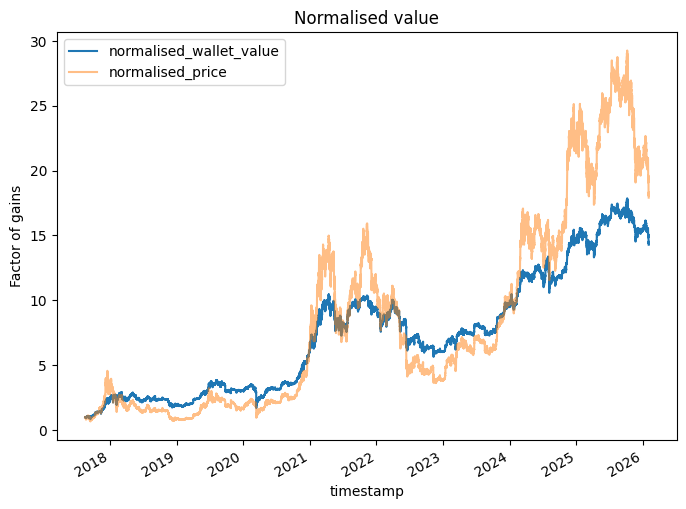

In [88]:
fig, ax = plt.subplots(figsize=(8, 6))

# Left panel
df.plot(ax=ax, x='timestamp', y='normalised_wallet_value', ylabel="Factor of gains", title="Normalised value")
df.plot(ax=ax, x='timestamp', y='normalised_price', alpha=0.5)


array([[<Axes: title={'center': 'trade_value'}>]], dtype=object)

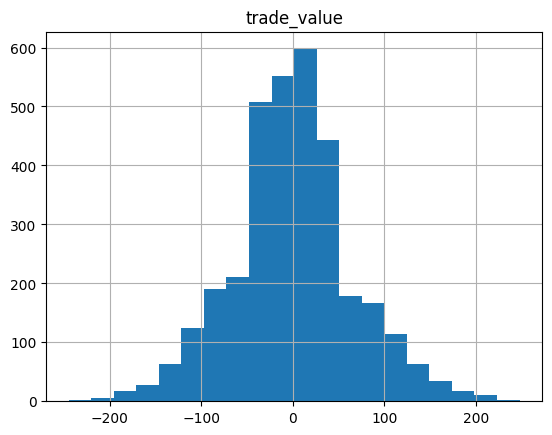

In [89]:
df.loc[df['signal'],['trade_value']].hist(bins=20)

In [15]:
def plot_profit(df):
    cum_max = round(df['max_profit'].sum())
    df.plot(x='timestamp',y='max_profit', ylabel = 'Profit (USD)', title = f'Cumulative max: ${cum_max}')

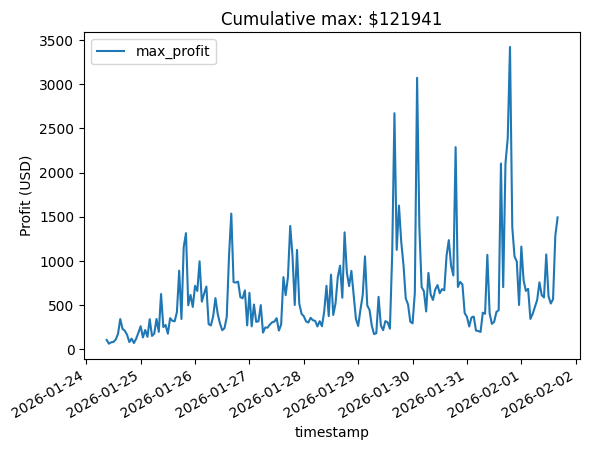

In [16]:
plot_profit(df_sample)

In [17]:
df['direction'].value_counts(normalize=True)

direction
 0    0.687767
-1    0.166617
 1    0.145616
Name: proportion, dtype: float64

## Fourier transform

In [18]:
# 5. Fourier analysis
price_series = df.set_index("timestamp")["price"]
returns = bb.detrend_series(price_series, method="log_return")

In [19]:
# 14-day rolling FFT on hourly data
fft_window = 24*7
dominant_cycles = bb.dominant_cycle(
    returns,
    window=fft_window,
    sampling_interval=1.0
)

In [20]:
# Align output
cycle_df = pd.DataFrame({
    "timestamp": returns.index[fft_window:],
    "dominant_cycle_hours": dominant_cycles
})

(0.0, 5.0)

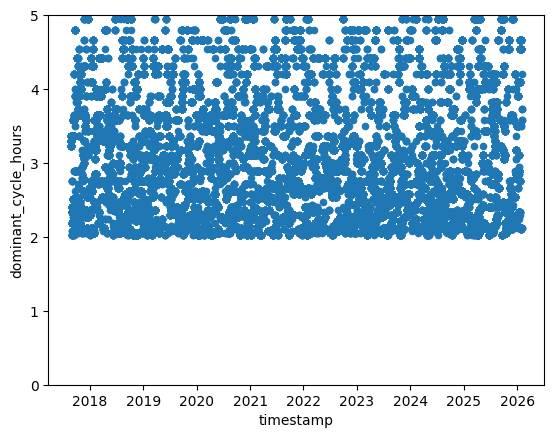

In [21]:
cycle_df.plot.scatter(x='timestamp',y='dominant_cycle_hours')
plt.ylim(0,5)

In [22]:
cycle_df.mean()

timestamp               2021-11-14 15:18:58.703241984
dominant_cycle_hours                         6.831204
dtype: object

In [23]:
cycle_df['dominant_cycle_hours'].value_counts()

dominant_cycle_hours
2.584615      1705
2.333333      1654
3.652174      1607
4.307692      1479
2.896552      1467
              ... 
12.000000      325
24.000000      311
11.200000      301
84.000000      299
168.000000     260
Name: count, Length: 83, dtype: int64

In [24]:
import sys
sys.executable


'/opt/homebrew/Cellar/jupyterlab/4.4.6/libexec/bin/python'